<a href="https://colab.research.google.com/github/andylynchul/ET5003_Assignments/blob/master/ET5003_Etivity2_ALynch_20208189.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-2

In [ ]:
#@title Current Date
Today = '2021-08-22' #@param {type:"date"}


In [ ]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20208189" #@param {type:"string"}
Student_full_name = "Andrew Lynch" #@param {type:"string"}
#@markdown ---

In [ ]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# INTRODUCTION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [ ]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import arviz as az
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [ ]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [ ]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# Functions

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-ET5003/ET5003_SEM1_2021-2/tree/main/Week-3). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

##Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Path, copy the path from your Drive
Path = '/content/drive/MyDrive/Masters/Year2/ET5003/Week3/Data/'

# House Data
train_data = Path + 'house_train.csv'
test_data = Path + 'house_test.csv'
cost_data = Path + 'true_price.csv'

# train data
df_train = pd.read_csv(train_data)

# test data
df_test = pd.read_csv(test_data)

# test data
df_cost = pd.read_csv(cost_data)

# test data
df_test = df_test.join(df_cost.drop("Id", axis=1))


print(df_train.shape)
print(df_test.shape)
print(df_cost.shape)

Mounted at /content/drive
(2982, 17)
(500, 17)
(500, 2)


# Exploritory Data Analysis

## High Level Analysis

In [ ]:
df_train.head()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,price,property_category,property_type,surface
0,996887,Portmarnock,NaN,NaN,NaN,Dublin,A SELECTION OF 4 AND 5 BEDROOM FAMILY HOMES LO...,prod,NaN,None,53.418216,-6.149329,18.0,NaN,new_development_parent,NaN,NaN
1,999327,Lucan,NaN,NaN,NaN,Dublin,**Last 2 remaining houses for sale ***\n\nOn v...,prod,NaN,None,53.364917,-6.454935,3.0,NaN,new_development_parent,NaN,NaN
2,999559,Rathfarnham,NaN,NaN,NaN,Dublin,Final 4 &amp; 5 Bedroom Homes for Sale\n\nOn V...,prod,NaN,None,53.273447,-6.313821,3.0,NaN,new_development_parent,NaN,NaN
3,9102986,Balbriggan,NaN,NaN,NaN,Dublin,"Glenveagh Taylor Hill, Balbriggan\n\r\n*Ideal ...",prod,NaN,None,53.608167,-6.210914,30.0,NaN,new_development_parent,NaN,NaN
4,9106028,Foxrock,NaN,NaN,NaN,Dublin,*New phase launching this weekend Sat &amp; Su...,prod,NaN,None,53.262531,-6.181527,8.0,NaN,new_development_parent,NaN,NaN


In [ ]:
df_train.tail()

,ad_id,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,price,property_category,property_type,surface
2977,12428232,Ballsbridge,2.0,2.0,C3,Dublin,Sherry FitzGerald are delighted to present Apa...,prod,NaN,Prime Location\nManagement Co: Core Property M...,53.338738,-6.237199,NaN,415000.0,sale,apartment,56.0
2978,12428240,Rialto,1.0,3.0,B2,Dublin,Property Team Patrick Moran is delighted to pr...,prod,NaN,Totally refurbished to the highest standard. \...,53.335793,-6.294268,NaN,485000.0,sale,terraced,101.0
2979,12428247,Smithfield,1.0,2.0,C3,Dublin,Earnest estate agents are delighted to present...,prod,Wired for Cable Television,OVERLOOKING THE RIVER LIFFEY \n3RD FLOOR APART...,53.346098,-6.276856,NaN,299000.0,sale,apartment,55.6
2980,12428254,Foxrock,2.0,3.0,C3,Dublin,Janet Carroll Estate Agents are pleased to pre...,prod,"Parking,Gas Fired Central Heating",None,53.273518,-6.178500,NaN,495000.0,sale,end-of-terrace,97.0
2981,12428358,Terenure,2.0,3.0,D2,Dublin,ON VIEW SATURDAY 7 TH MARCH 2020 11:30 AM - 12...,prod,NaN,Charming three-bedroom family home\nMinutes aw...,53.310073,-6.325158,NaN,525000.0,sale,semi-detached,129.3


On inital review features and description_block look like candidates for removal.

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2982 entries, 0 to 2981
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ad_id               2982 non-null   int64  
 1   area                2982 non-null   object 
 2   bathrooms           2931 non-null   float64
 3   beds                2931 non-null   float64
 4   ber_classification  2305 non-null   object 
 5   county              2982 non-null   object 
 6   description_block   2982 non-null   object 
 7   environment         2982 non-null   object 
 8   facility            965 non-null    object 
 9   features            2982 non-null   object 
 10  latitude            2982 non-null   float64
 11  longitude           2982 non-null   float64
 12  no_of_units         59 non-null     float64
 13  price               2892 non-null   float64
 14  property_category   2982 non-null   object 
 15  property_type       2931 non-null   object 
 16  surfac

In [ ]:
df_train.describe()

,ad_id,bathrooms,beds,latitude,longitude,no_of_units,price,surface
count,2.982000e+03,2931.000000,2931.000000,2982.000000,2982.000000,59.000000,2.892000e+03,2431.000000
mean,1.224065e+07,1.998635,2.979188,53.355991,-6.257175,7.440678,5.323536e+05,318.851787
std,5.793037e+05,1.291875,1.468408,0.086748,0.141906,8.937081,5.678148e+05,4389.423136
min,9.968870e+05,0.000000,0.000000,51.458439,-6.521183,0.000000,1.999500e+04,3.400000
25%,1.226813e+07,1.000000,2.000000,53.298929,-6.314064,2.000000,2.800000e+05,74.100000
50%,1.237758e+07,2.000000,3.000000,53.345497,-6.252254,3.000000,3.800000e+05,100.000000
75%,1.240294e+07,3.000000,4.000000,53.388845,-6.196049,8.000000,5.750000e+05,142.000000
max,1.242836e+07,18.000000,27.000000,53.630588,-1.744995,36.000000,9.995000e+06,182108.539008


In [ ]:
# Use this to get some high level information about the missing data
df_train.isna().sum()

ad_id                    0
area                     0
bathrooms               51
beds                    51
ber_classification     677
county                   0
description_block        0
environment              0
facility              2017
features                 0
latitude                 0
longitude                0
no_of_units           2923
price                   90
property_category        0
property_type           51
surface                551
dtype: int64

In [ ]:
# Find the number of nulls/NaNs in the dataset as a percentage to see if any columns need to be considered for removal
print("Read of missing values as percentage of data set")
df_train.isna().sum()*100/len(df_train)

Read of missing values as percentage of data set


ad_id                  0.000000
area                   0.000000
bathrooms              1.710262
beds                   1.710262
ber_classification    22.702884
county                 0.000000
description_block      0.000000
environment            0.000000
facility              67.639168
features               0.000000
latitude               0.000000
longitude              0.000000
no_of_units           98.021462
price                  3.018109
property_category      0.000000
property_type          1.710262
surface               18.477532
dtype: float64

From analysis of missing values no_of_units and faclility look likely to be dropped as they are ouside the 25% threshold

## High Level Correleation Analysis

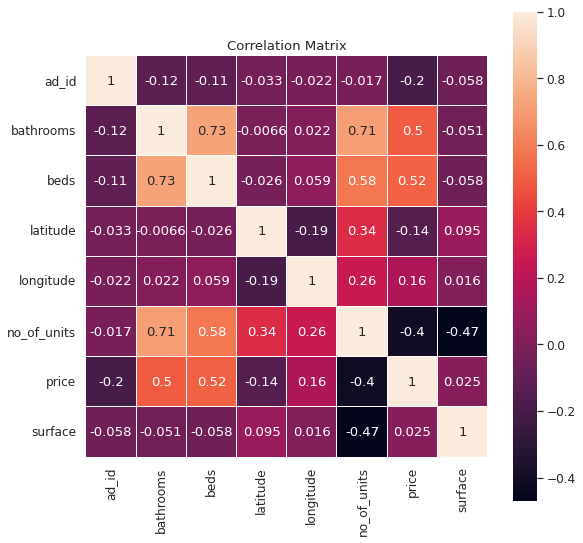

In [ ]:
# calculate the correlation matrix
corr = df_train.corr()

# plot the heatmap
sns.set(font_scale=1.10)
plt.figure(figsize=(9, 9))
plt.title('Correlation Matrix')
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,linewidths=0.01,square=True,annot=True)

Correlation Matrix shows a positive correlation between Price, Bedreooms (0.52) and Bathrooms (0.5) pointing towards these as to potential selections for important features.

Pairplots of numerical features


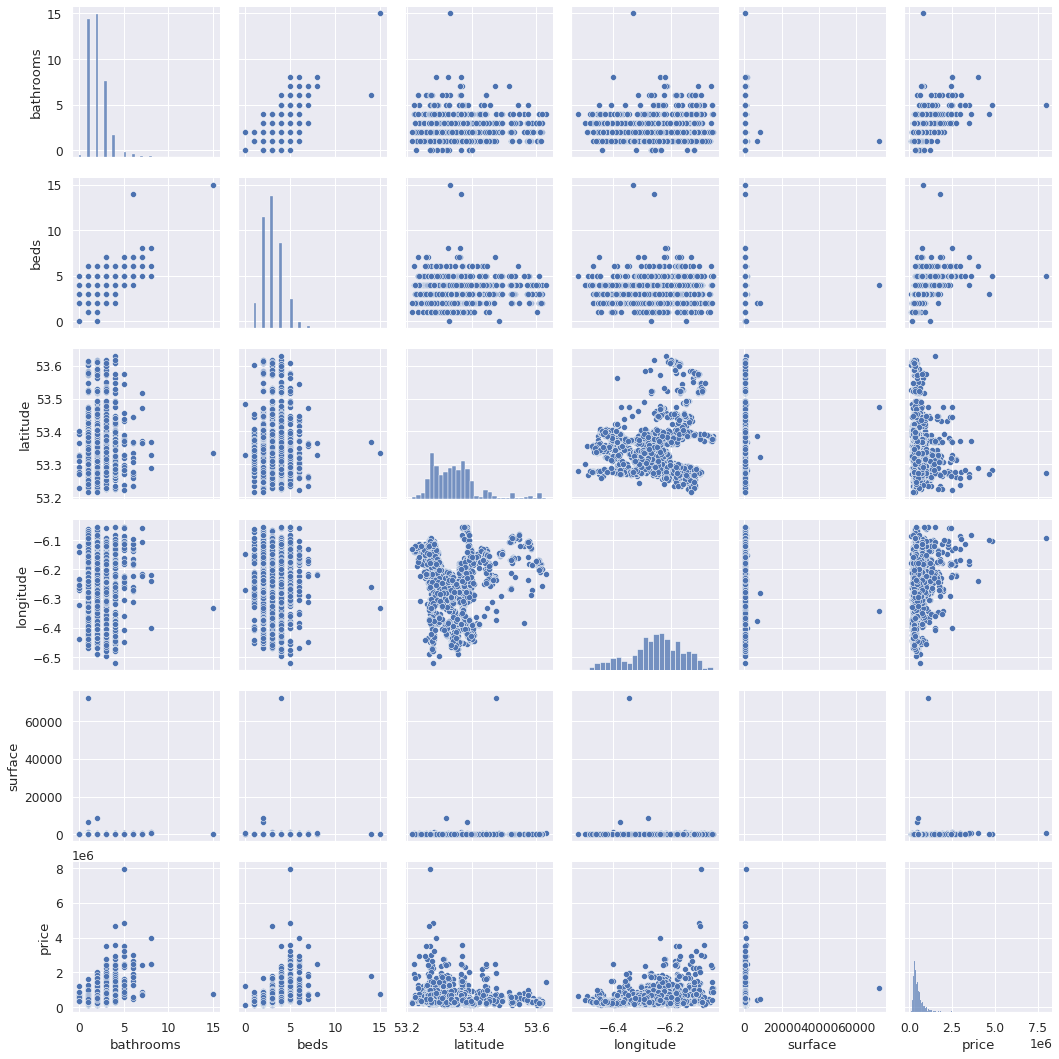

In [ ]:

# Pairplot to see the relationship between numerical features. The method dropna() drops all rows with missing values 
# No of units and facility are removed due to high number of NULL values
print('Pairplots of numerical features')
sns.pairplot(data=df_train[['bathrooms','beds','ber_classification','latitude','longitude','surface','price']].dropna())
plt.show()

By analysing the PAirwise plots it can be seen that dome of the features are suffering from outlier effects. Bathrooms, Beds, Surface, 

##Categorical Data Analysis

In [ ]:
# Get a read of Categorical Values
cat_cols = df_train.select_dtypes(include=['object'])     #strip out the categorical cols
cat_cols.columns[cat_cols.any()].tolist()           #convert col names to list
for i in cat_cols:                                  #loop through the cols
    print(cat_cols[i].value_counts(),"\n")          #print the summary to analyse

Finglas          94
Castleknock      90
Rathfarnham      87
Malahide         81
Lucan            79
                 ..
Ard Na Greine     1
Coolmine          1
Kiltipper         1
Hartstown         1
Oldbawn           1
Name: area, Length: 156, dtype: int64 

D1                     283
D2                     274
C3                     268
C2                     242
C1                     212
E1                     182
E2                     169
G                      166
F                      165
B3                     130
B2                      74
A3                      70
SINo666of2006exempt     28
A2                      25
B1                      16
A1                       1
Name: ber_classification, dtype: int64 

Dublin    2982
Name: county, dtype: int64 

LEONARD WILSON KEENAN ESTATE &amp; LETTING AGENTS \r\nOur business is you ....\n\r\nEXTRA SPACIOUS EXTENDED 3 BED / 1 BATH SEMI DETACHED BUNGALOW ON LARGE SITE \r\nSOUTH WEST FACING BACK GARDEN \r\nEXCELLENT FURTHER POTENTI

In [ ]:
drop_features = ['ad_id','area','property_category','description_block', 'features','no_of_units','facility', 'environment', 'county']

df_train_eda = df_train.drop(drop_features, axis=1)

# Get a read of Categorical Values
cat_cols = df_train_eda.select_dtypes(include=['object'])     #strip out the categorical cols
cat_cols.columns[cat_cols.any()].tolist()           #convert col names to list
for i in cat_cols:                                  #loop through the cols
    print(cat_cols[i].value_counts(),"\n")          #print the summary to analyse

D1                     283
D2                     274
C3                     268
C2                     242
C1                     212
E1                     182
E2                     169
G                      166
F                      165
B3                     130
B2                      74
A3                      70
SINo666of2006exempt     28
A2                      25
B1                      16
A1                       1
Name: ber_classification, dtype: int64 

apartment         759
semi-detached     754
terraced          554
detached          398
end-of-terrace    237
bungalow           84
duplex             60
site               55
townhouse          27
studio              3
Name: property_type, dtype: int64 



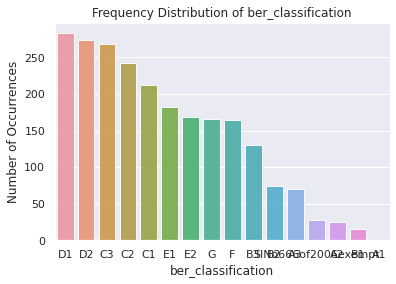

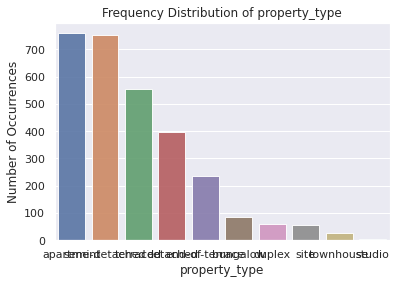

In [ ]:
# Get a read of Categorical Values Visualy (Frequency Distribution Plots)
for i in cat_cols:                                  #loop through the cols
    plot_count = cat_cols[i].value_counts()
    sns.set(style="darkgrid")
    sns.barplot(plot_count.index, plot_count.values, alpha=0.9)
    plt.title('Frequency Distribution of '+cat_cols[i].name)
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel(cat_cols[i].name, fontsize=12)
    plt.show()

## Analysis of BER Rating
BER is identified as a feature that will add value to the model and is missing 622 (22%) values so some further anaysis of this data is warranted. It is just withing the 25% threshold for removal and is well distributed across the data set

Text(0.5, 1.0, 'Count of BER for 2nd hand properties')

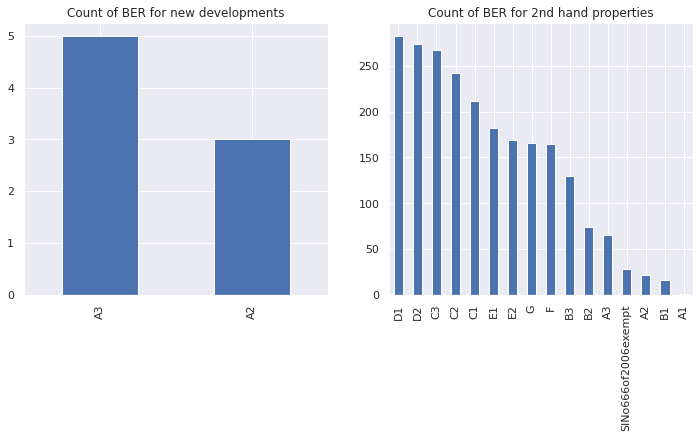

In [ ]:
# Courtesy of Carlos during our forum discussons
# Plot couting of BER rating by property category 

ber_new=df_train[df_train['property_category']=='new_development_parent']
ber_used=df_train[df_train['property_category']=='sale']

plt.subplots(2,2,figsize=(12,5))
plt.subplot(1, 2, 1) 
ber_new['ber_classification'].value_counts().plot(kind='bar')
plt.title('Count of BER for new developments')
plt.subplot(1, 2, 2) 
ber_used['ber_classification'].value_counts().plot(kind='bar')
plt.title('Count of BER for 2nd hand properties')

BER rating is missing for 22% of the records. A breakdown of BER by property category - new development or sale (2nd hand) - shows that all new developments are either rating A2 or A3. On the other hand, very few 2nd hand properties are rating A. Imputtng the average BER rating to 2nd hand propertied where missing taking the property category into account as all new developments are rating A. Property_category is not deemed useful for the modelling but useful to impute the missing BER data.

## Numerical Data Analysis

In [ ]:
#Calculate missing values for the numerical features.
print(df_train.select_dtypes(exclude=['object']).isna().sum())

ad_id             0
bathrooms        51
beds             51
latitude          0
longitude         0
no_of_units    2923
price            90
surface         551
dtype: int64


## EDA Summary
1. On initial examination of the data it was clear **description_block** and **features** were not in any format to systematically encode so it was decided early that these features could be discarded.
2. On analysis of the missing values it was seen that **no_of_units** and **facilities** had more than 25% of their values missing which meant these features could be removed from further analysis
3. Both **environment** and **county** both are single values through out offering no value so can be disregarded from further analysis
4. **ad_id** is just the data index and offers no value so can be disregarded from further analysis
5. **Area** is an interesting one as it has 156 unique entries and clearly could offer some value in the prediction of price. In the context of this problem, it was felt by one-hot encoding the data would lead to too many features running the risk of producing low signal regressors [Johannemann et al. 2020].
6. **property_category** was another tricky one. It was examnied and felt the data was heavily skewed towards sale (accouting for 98% of the data set) so this would not be used in building the model. The data was used to impute the mossing BER values for 2nd hand houses (Carlos)
7.  
 
 
 



#Data Preparation

## Feature Selection

In [ ]:
# Drop the Text Based Features, Low Value Features
# ad_id : Index - no added value
# description_block, features : content based, cannot be transfered to numeric
# no_of_units, faciities : more than 25% with no values
# enviroment, county : no added value
# property_category : data skewed heavily towards sale - felt it added no value
# area : one hot encoding leading to too many low value regressors x 193

drop_features = ['ad_id','area','property_category','description_block', 'features','no_of_units','facility', 'environment', 'county']

df_train_p = df_train.drop(drop_features, axis=1)
df_test_p = df_test.drop(drop_features, axis=1)

## Encoding of Categorical Data

### BER Rating (Ordinal Encoding)

In [ ]:
#Convert BER classification into ordinal features
# Map BER categories 
if 'ber_classification' in df_train_p:
  BERMap = {
      "A1": 1,
      "A2": 2,
      "A3": 3,
      "B1": 4,
      "B2": 5,
      "B3": 6,
      "C1": 7,
      "C2": 8,
      "C3": 9,
      "D1": 10,
      "D2": 11,
      "E1": 12,
      "E2": 13,
      "F": 14,
      "G": 15,
      "SINo666of2006exempt" : 0
  }
  df_train_p['ber_classification'] = df_train_p['ber_classification'].replace(BERMap)
  df_test_p['ber_classification'] = df_test_p['ber_classification'].replace(BERMap)

In [ ]:
# Replace 'N/A' values in ber_classification with mean of the same property category
if 'ber_classification' in df_train_p:
  ber_avg_set = df_train_p[df_train['property_category']=='sale']
  ber_avg_val = round(ber_avg_set['ber_classification'].mean(),0) # mean of ber classification rounded to the nearest whole number. 

  df_train_p['ber_classification'].fillna(ber_avg_val, inplace=True) # Only 2nd hand properties are missing BER. Therefore, we input the average for 2nd hand ones

  print("BER classification replacing missing values for 2nd hand properties: ",ber_avg_val)

BER classification replacing missing values for 2nd hand properties:  10.0


### Property Category (On Hot Encoding)

In [ ]:
#one hot encode all the remaining categorical fields

if 'property_type' in df_train_p:
  # strip out the columns of type object that have nan's
  cols_ohe =  ['property_type']

  # now one-hot encode all categorical columns with nan
  df_train_p = pd.get_dummies(df_train_p, columns=cols_ohe, 
                          dummy_na=True, 
                          drop_first=True)

  # now one-hot encode all categorical columns with nan
  df_test_p = pd.get_dummies(df_test_p, columns=cols_ohe, 
                          dummy_na=True, 
                          drop_first=True)
  df_train_p.tail()

## Dealing with Missing Values

In [ ]:
# First filter out those rows that
# do not contain any data
df_train_p.dropna(subset=['price'], axis=0, inplace=True) 
df_train_p.drop(df_train_p[df_train_p['beds'] == 0].index, inplace = True)
df_train_p.drop(df_train_p[df_train_p['bathrooms'] == 0].index, inplace = True)
df_train_p['surface'].fillna(df_train_p['surface'].mean(), inplace=True)
print(df_train_p.select_dtypes(exclude=['object']).isna().sum())

# Apply to test data set
#df_test_p.drop(df_test_p[df_test_p['beds'] == 0].index, inplace = True)
#df_test_p.drop(df_test_p[df_test_p['bathrooms'] == 0].index, inplace = True)
#df_test_p['surface'].fillna(df_test_p['surface'].mean(), inplace=True)

bathrooms                       0
beds                            0
ber_classification              0
latitude                        0
longitude                       0
price                           0
surface                         0
property_type_bungalow          0
property_type_detached          0
property_type_duplex            0
property_type_end-of-terrace    0
property_type_semi-detached     0
property_type_site              0
property_type_studio            0
property_type_terraced          0
property_type_townhouse         0
property_type_nan               0
dtype: int64


## Detection & Removal of Outliers

In [ ]:
# Function to Detection Outlier on one-dimentional datasets.
def remove_outliers(dframe, feature):
    '''Function to Detect / Remove Outliers'''
  
    #define a list to accumlate anomalies
    anomalies = []
    
    # Set upper and lower limit to 3 standard deviation
    random_data_std = np.std(dframe[feature])
    random_data_mean = np.mean(dframe[feature])
    anomaly_cut_off = random_data_std * 3
    
    lower_limit  = random_data_mean - anomaly_cut_off 
    upper_limit = random_data_mean + anomaly_cut_off
    
    dframe = dframe.drop(dframe[(dframe[feature] < lower_limit) | (dframe[feature] > upper_limit)].index)

    return dframe

def plot_box_hist(dframe, features):
    '''Function to plot Box / Histogram pair for any feature'''
    no_feats = len(features)
  
    figH = plt.figure(figsize=(30,no_feats*5))

    for i in range(0, no_feats): 
        ax1 = figH.add_subplot(no_feats, 2, (i*2)+1)
        ax1.set_title("Boxplot of "+features[i])
        dframe.boxplot(column=[features[i]])

        ax2 = figH.add_subplot(no_feats, 2, (i*2)+2)
        ax2.set_title("Histogram of "+features[i])
        dframe[features[i]].hist(bins=20)

    plt.show()


Analysis of outliers


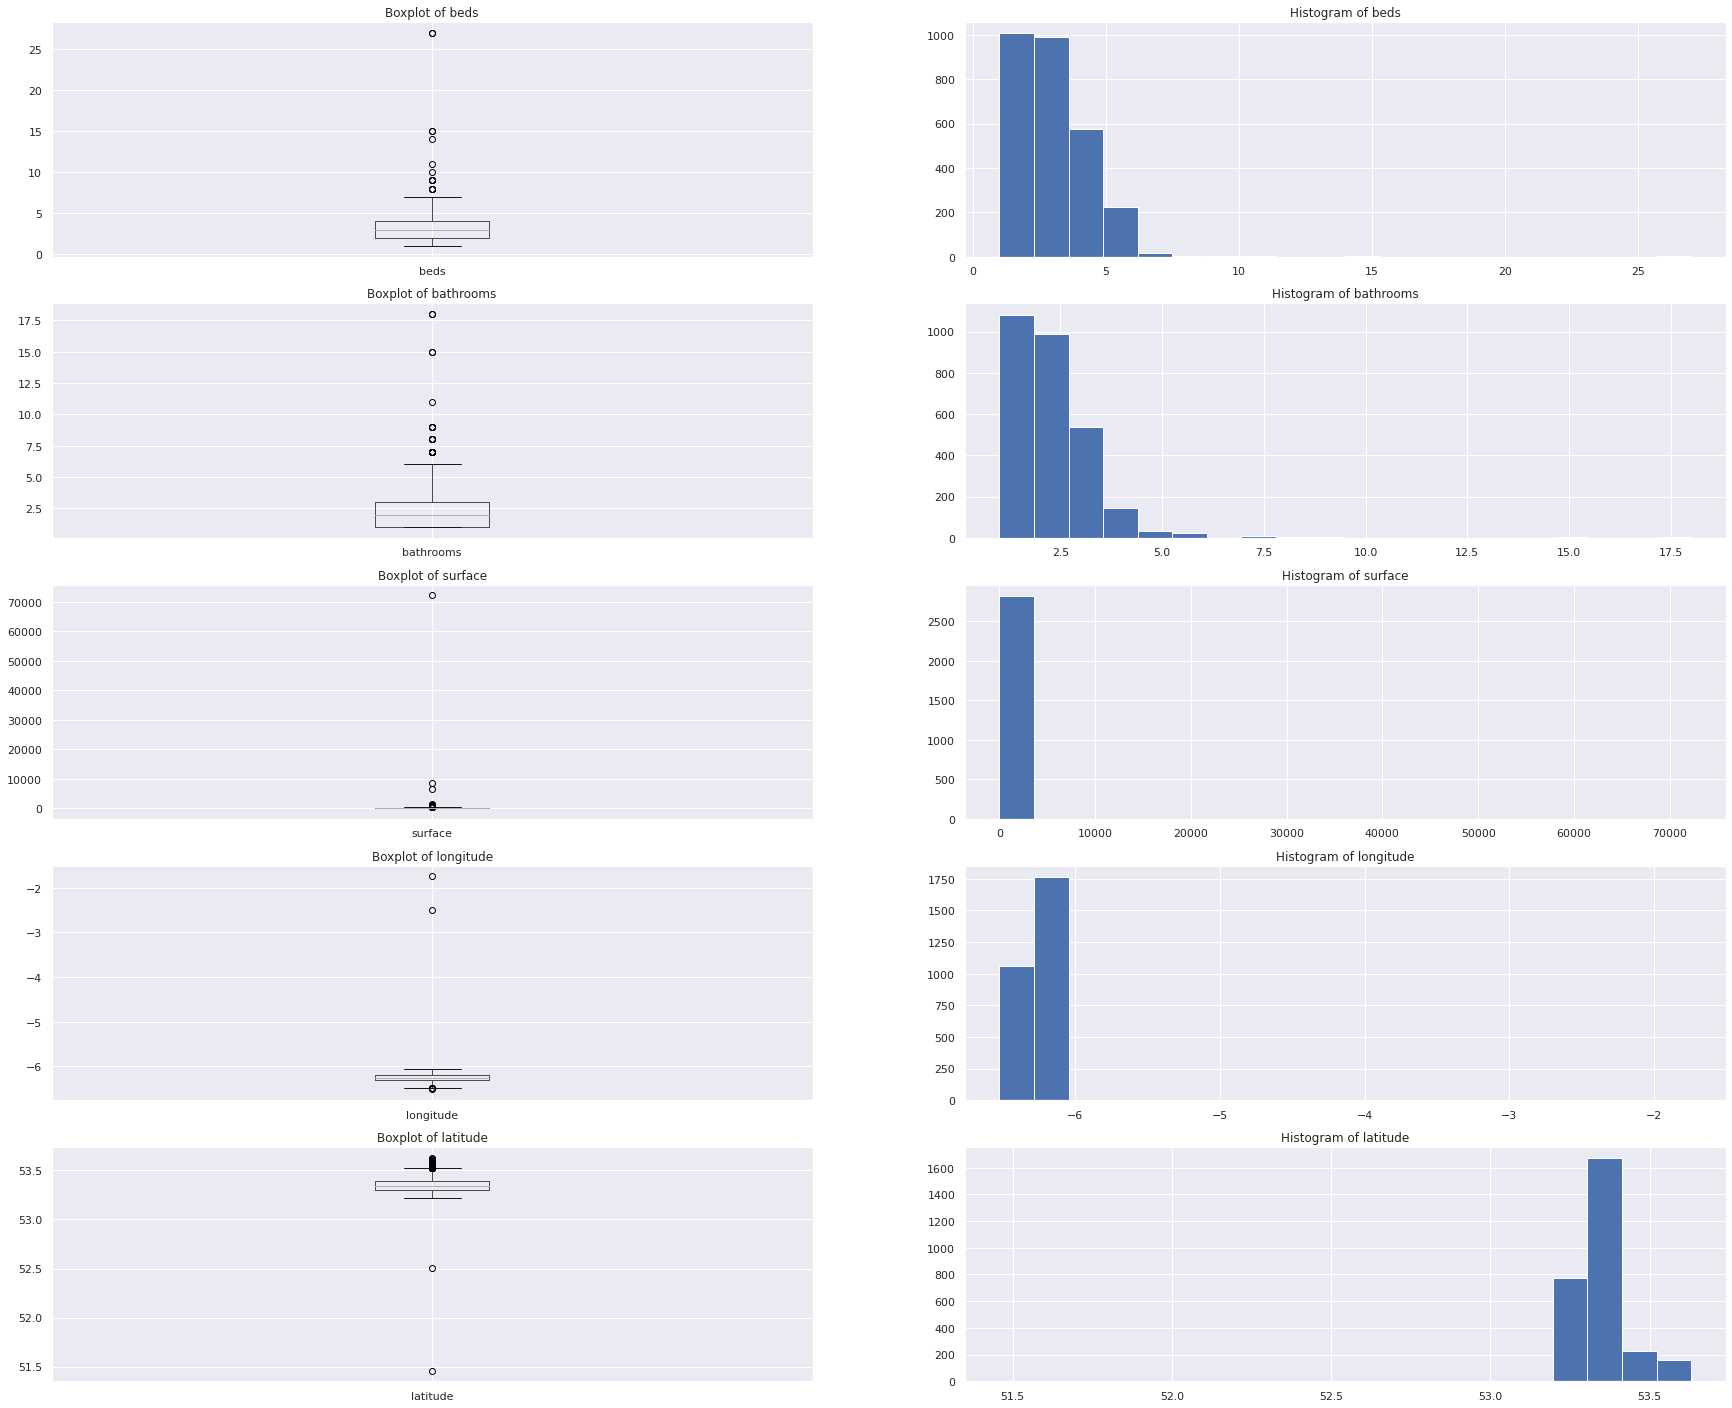

(2828, 17)
After outliers have been removed


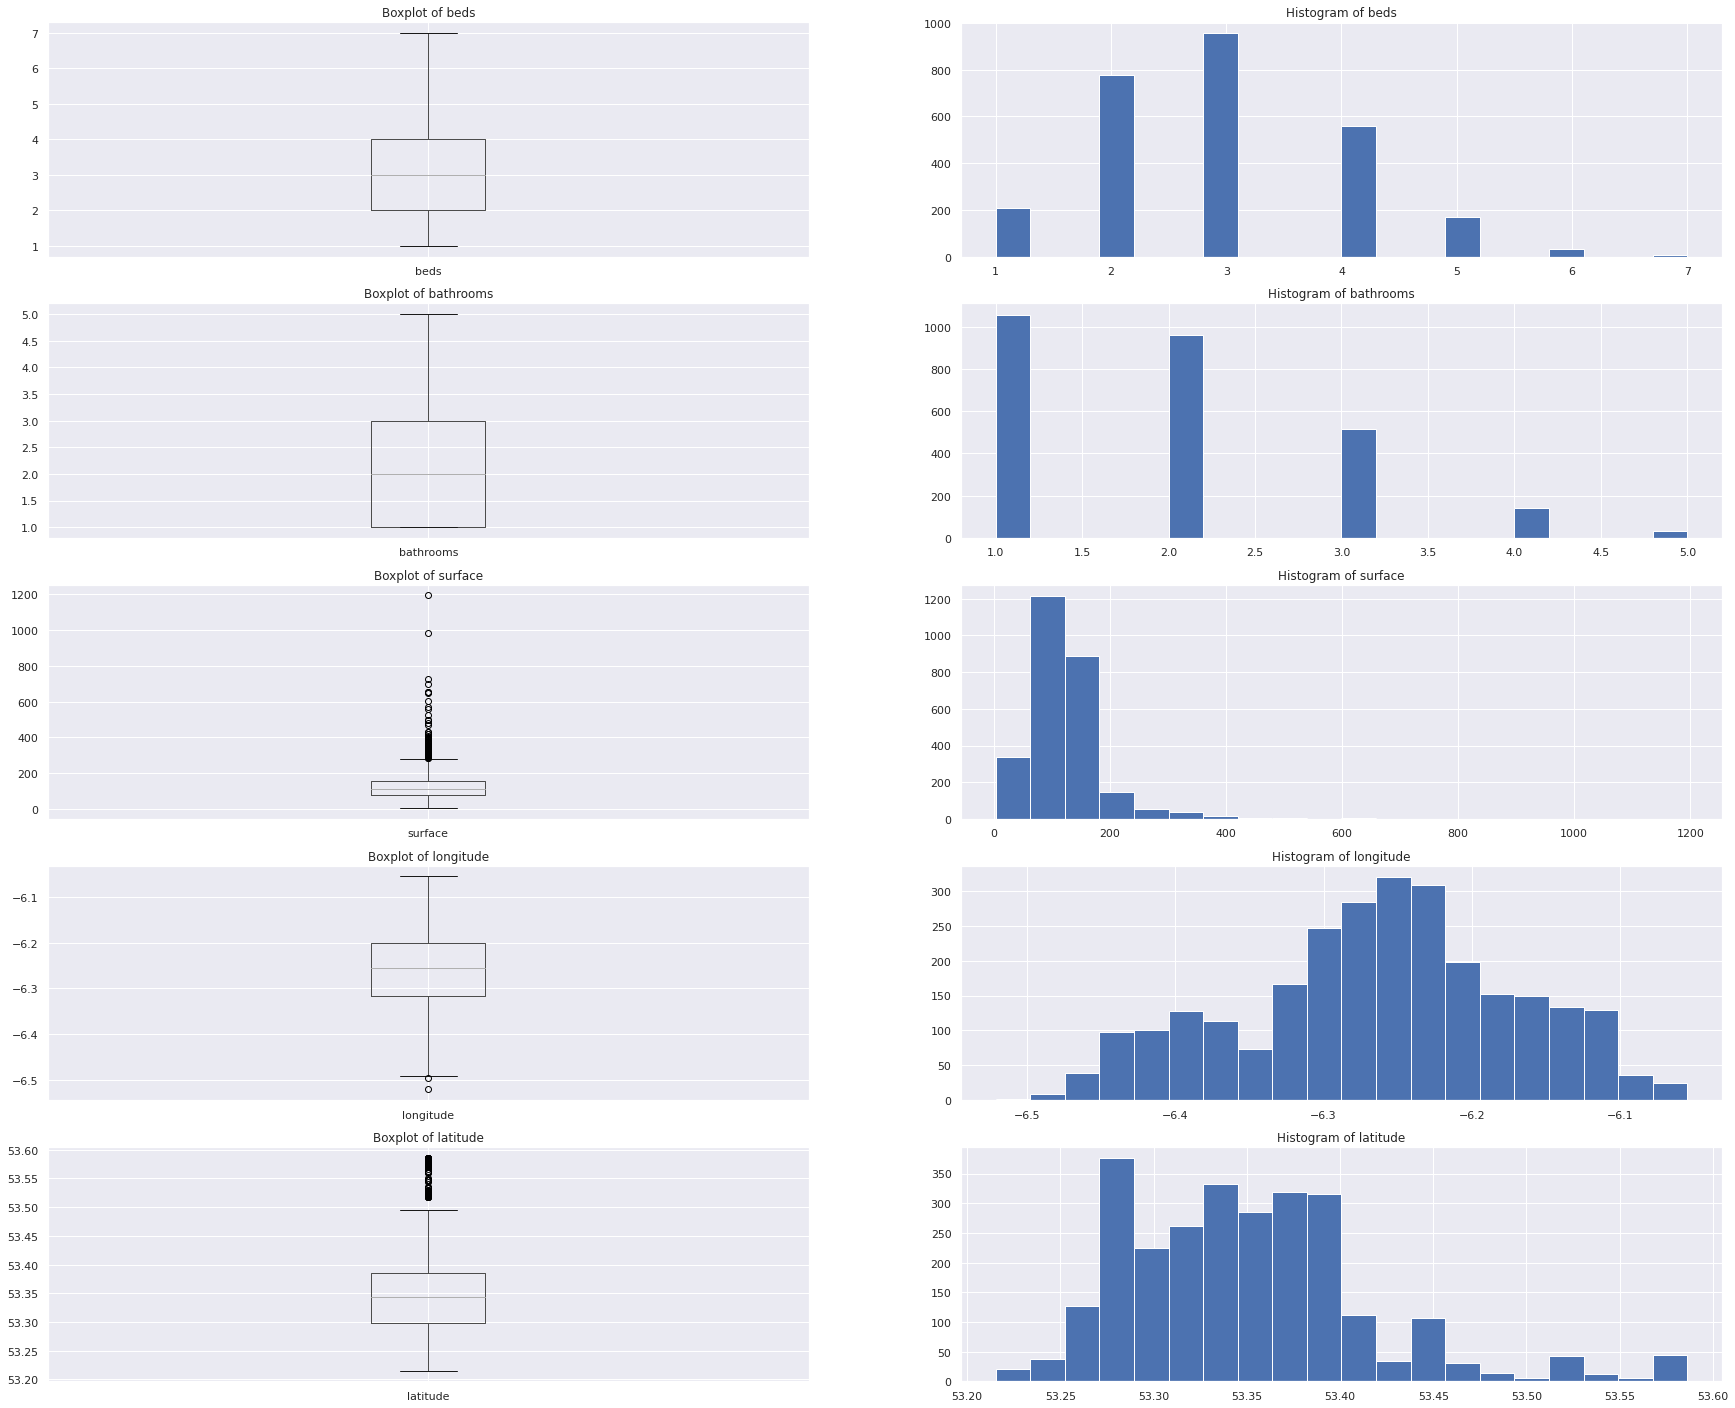

(2709, 17)


In [ ]:
#Select features to include in plots
include_featues = ['beds','bathrooms','surface','longitude','latitude']

#run print function
print("Analysis of outliers")
plot_box_hist(df_train_p, include_featues)
print(df_train_p.shape)

print("After outliers have been removed")
for i in range(0, len(include_featues)): 
    df_train_p = remove_outliers(df_train_p,include_featues[i])
    #df_test_p = remove_outliers(df_test_p,include_featues[i])

#run print function
plot_box_hist(df_train_p, include_featues)
print(df_train_p.shape)

In [ ]:
sns.pairplot(data=df_train[['bathrooms','beds','ber_classification','latitude','longitude','surface','price']].dropna())
plt.show()

## Training & Test Data

### Train dataset

In [ ]:
# show first data frame rows 
df_train_p.head()

,bathrooms,beds,ber_classification,latitude,longitude,price,surface,property_type_bungalow,property_type_detached,property_type_duplex,property_type_end-of-terrace,property_type_semi-detached,property_type_site,property_type_studio,property_type_terraced,property_type_townhouse,property_type_nan
15,3.0,5.0,3.0,53.400454,-6.445730,935000.0,321.0,0,1,0,0,0,0,0,0,0,0
26,4.0,4.0,3.0,53.316410,-6.385214,485000.0,144.0,0,0,0,0,1,0,0,0,0,0
27,3.0,5.0,3.0,53.401414,-6.446634,935000.0,321.0,0,1,0,0,0,0,0,0,0,0
35,5.0,5.0,2.0,53.375377,-6.056749,1475000.0,312.0,0,1,0,0,0,0,0,0,0,0
38,2.0,2.0,3.0,53.372130,-6.338466,410000.0,83.0,0,0,0,0,0,0,0,0,0,0


### Test dataset

In [ ]:
# show first data frame rows 
df_test_p.head()

,bathrooms,beds,ber_classification,latitude,longitude,surface,Expected,property_type_bungalow,property_type_detached,property_type_duplex,property_type_end-of-terrace,property_type_semi-detached,property_type_site,property_type_studio,property_type_terraced,property_type_townhouse,property_type_nan
0,2.0,4.0,15.0,53.566881,-6.101148,142.0,875000.0,1,0,0,0,0,0,0,0,0,0
1,2.0,3.0,7.0,53.362992,-6.452909,114.0,355000.0,0,0,0,0,0,0,0,1,0,0
2,3.0,4.0,6.0,53.454198,-6.262964,172.0,440000.0,0,0,0,0,1,0,0,0,0,0
3,4.0,3.0,3.0,53.354402,-6.458647,132.4,425000.0,0,0,0,0,1,0,0,0,0,0
4,1.0,3.0,13.0,53.336530,-6.393587,88.0,265000.0,0,0,0,0,1,0,0,0,0,0


### Expected Cost dataset

In [ ]:
# Generate descriptive statistics
df_cost = df_cost.drop("Id", axis=1)
df_cost.head()

,Expected
0,875000.0
1,355000.0
2,440000.0
3,425000.0
4,265000.0


In [ ]:
print(df_train_p.shape)
print(df_test_p.shape)
print(df_cost.shape)

(2709, 17)
(500, 17)
(500, 1)


# Piecewise Regression

In [ ]:
# split data into training and test
from sklearn.model_selection import train_test_split

X = df_train_p.drop("price",axis=1)
y = df_train_p["price"]

# training: 70% (0.7), test: 30% (0.3)
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3)

print(X_train.shape)
print(y_train.shape)

(1896, 16)
(1896,)


## Full Model

In [ ]:
# select some features columns just for the baseline model
# assume not all of the features are informative or useful
# in this exercise you could try all of them if possible

# featrain = ['feature_1','feature_2','feature_3','cost']
# dropna: remove missing values
df_subset_train = X_train.dropna(axis=0)

# featest = ['feature_1','feature_2','feature_3']
df_subset_test = X_test.dropna(axis=0)

# Filter out costs so the counts match
df_cost_subset = df_cost[df_cost.index.isin(df_subset_train.index)]

In [ ]:
# train set, input columns
Xs_train = df_subset_train.iloc[:,0:-1].values 
# train set, output column, cost
ys_train = y_train.values.reshape(-1,1)   

# test set, input columns
Xs_test = df_subset_test.iloc[:,0:-1].values 
# test set, output column, cost
y_cost_test = df_cost_subset.Expected.values

print(Xs_train.shape)
print(ys_train.shape)
print(Xs_test.shape)
print(y_test.shape)

(1896, 15)
(1896, 1)
(813, 15)
(813,)


In [ ]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1#

sc = StandardScaler()

Xss_train = np.hstack([Xs_train,Xs_train[:,[2]]**2])
xscaler = sc.fit(Xs_train)
Xn_train = xscaler.transform(Xs_train)

Xss_test = np.hstack([Xs_test,Xs_test[:,[2]]**2])
Xn_test = xscaler.transform(Xs_test)

ylog = np.log(ys_train.astype('float'))
yscaler = StandardScaler().fit(ylog)
yn_train = yscaler.transform(ylog)

In [ ]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn_train.T)
    #likelihood, be sure that observed is a 1d vector
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])
    

Finished [100%]: Average Loss = 1,743.9


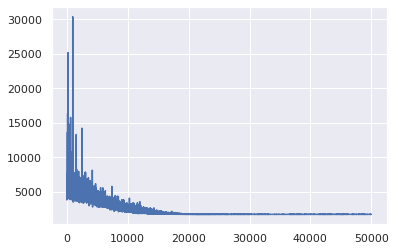

In [ ]:
#number of iterations of the algorithms
iter = 50000 

# run the model
with model:
    approximation = pm.fit(iter,method='advi')
    
# check the convergence
plt.plot(approximation.hist);

In [ ]:
# samples from the posterior
posterior = approximation.sample(5000)

In [ ]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print("MAE = ",(np.mean(abs(y_pred_BLR - y_test))))
print("MAPE = ",(np.mean(abs(y_pred_BLR - y_test) / y_test)))

MAE =  148688.90348477682
MAPE =  0.24185462795873106


## Clustering

### Full Model

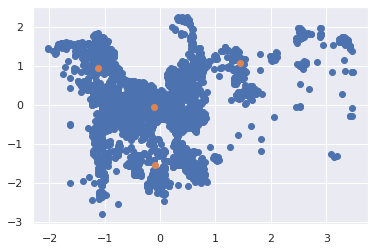

In [ ]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4)
# clustering by features 1, 2
ind=[3,4]
X_ind = np.vstack([Xn_train[:,ind],Xn_test[:,ind]])
# Gaussian Mixture
gmm.fit(X_ind)
# plot blue dots
plt.scatter(X_ind[:,0],X_ind[:,1])
# centroids:  orange dots
plt.scatter(gmm.means_[:,0],gmm.means_[:,1])

### Clusters

In [ ]:
# train clusters
clusters_train = gmm.predict(Xn_train[:,ind])
unique_train, counts_train = np.unique(clusters_train, return_counts=True)
dict(zip(unique_train, counts_train))

{0: 291, 1: 298, 2: 352, 3: 955}

In [ ]:
# test clusters
clusters_test = gmm.predict(Xn_test[:,ind])
unique_test, counts_test = np.unique(clusters_test, return_counts=True)
dict(zip(unique_test, counts_test))

{0: 142, 1: 101, 2: 149, 3: 421}

In [ ]:
# cluster 0
Xn0 = Xn_train[clusters_train==0,:]
Xtestn0 = Xn_test[clusters_test==0,:]
ylog0 = np.log(ys_train.astype('float')[clusters_train==0,:])
yscaler0 = StandardScaler().fit(ylog0)
yn0 = yscaler0.transform(ylog0)

In [ ]:
# cluster 1
Xn1 = Xn_train[clusters_train==1,:]
Xtestn1 = Xn_test[clusters_test==1,:]
ylog1 = np.log(ys_train.astype('float')[clusters_train==1,:])
yscaler1 = StandardScaler().fit(ylog1)
yn1 = yscaler1.transform(ylog1)

In [ ]:
# cluster 2
Xn2 = Xn_train[clusters_train==2,:]
Xtestn2 = Xn_test[clusters_test==2,:]
ylog2 = np.log(ys_train.astype('float')[clusters_train==2,:])
yscaler2 = StandardScaler().fit(ylog2)
yn2 = yscaler2.transform(ylog2)

In [ ]:
# cluster 3
Xn3 = Xn_train[clusters_train==3,:]
Xtestn3 = Xn_test[clusters_test==3,:]
ylog3 = np.log(ys_train.astype('float')[clusters_train==3,:])
yscaler3 = StandardScaler().fit(ylog3)
yn3 = yscaler3.transform(ylog3)

## Piecewise Model

In [ ]:
# model_0
with pm.Model() as model_0:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn0.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn0.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn0[:,0])

with model_0:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior0 = approximation.sample(5000)



Finished [100%]: Average Loss = 301.1


In [ ]:
# model_1
with pm.Model() as model_1:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn1.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn1.T)
  # likelihood, # 
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn1[:,0])
  
with model_1:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior1 = approximation.sample(5000)

Finished [100%]: Average Loss = 342.03


In [ ]:
# model_2
with pm.Model() as model_2:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn2.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  # linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn2.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn2[:,0])
    
with model_2:
  # iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior2 = approximation.sample(5000)

Finished [100%]: Average Loss = 365.94


In [ ]:
# model_3
with pm.Model() as model3:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn3.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  mu = alpha + pm.math.dot(beta, Xn3.T)#linear regression model in matrix form
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn3[:,0])
    
with model3:
  # number of iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior     
posterior3 = approximation.sample(5000)

Finished [100%]: Average Loss = 893.91


##Simulations

In [ ]:
# Posterior predictive checks (PPCs)
def ppc(alpha,beta,sigma, X,  nsamples=500):
    #we select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        #we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T +np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
    return Ypred


### Only Cluster 0

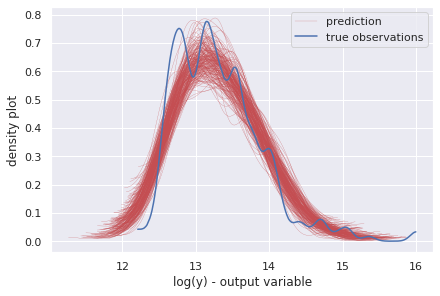

In [ ]:
#Simulation
Ypred0 = yscaler0.inverse_transform(ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200))
for i in range(Ypred0.shape[0]):
    az.plot_dist( Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog0,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

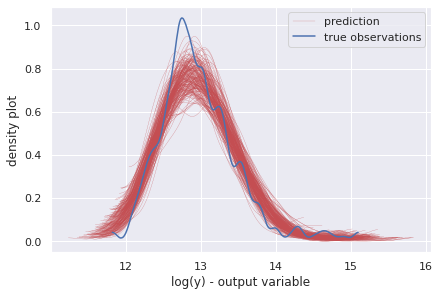

In [ ]:
#Simulation
Ypred1 = yscaler1.inverse_transform(ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200))
for i in range(Ypred1.shape[0]):
    az.plot_dist( Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog1,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

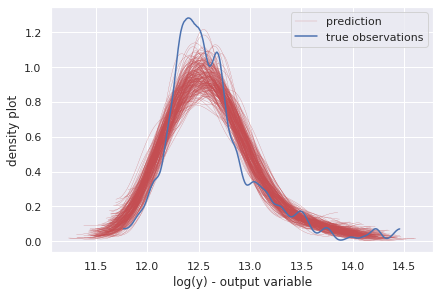

In [ ]:
#Simulation
Ypred2 = yscaler2.inverse_transform(ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200))
for i in range(Ypred2.shape[0]):
    az.plot_dist( Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog2,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

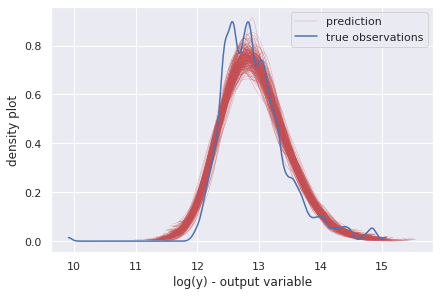

In [ ]:
#Simulation
Ypred3 = yscaler3.inverse_transform(ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,nsamples=200))
for i in range(Ypred3.shape[0]):
    az.plot_dist( Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog3,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

## Overall

## Test set performance

In [ ]:
# cluster 0
y_pred_BLR0 = np.exp(yscaler0.inverse_transform(np.mean(posterior0['alpha']) 
              + np.dot(np.mean(posterior0['beta'],axis=0), Xtestn0.T)))
print("Size Cluster0", np.sum(clusters_test==0), ", MAE Cluster0=",
      (np.mean(abs(y_pred_BLR0 - y_test[clusters_test==0]))))

# cluster 1
y_pred_BLR1 = np.exp(yscaler1.inverse_transform(np.mean(posterior1['alpha']) 
              + np.dot(np.mean(posterior1['beta'],axis=0), Xtestn1.T)))
print("Size Cluster1", np.sum(clusters_test==1), ", MAE Cluster1=",
      (np.mean(abs(y_pred_BLR1 - y_test[clusters_test==1]))))

# cluster 2
y_pred_BLR2 = np.exp(yscaler2.inverse_transform(np.mean(posterior2['alpha']) 
              + np.dot(np.mean(posterior2['beta'],axis=0), Xtestn2.T)))
print("Size Cluster2", np.sum(clusters_test==2), ", MAE Cluster2=",
      (np.mean(abs(y_pred_BLR2 - y_test[clusters_test==2]))))

# cluster 3
y_pred_BLR3 = np.exp(yscaler3.inverse_transform(np.mean(posterior3['alpha']) 
              + np.dot(np.mean(posterior3['beta'],axis=0), Xtestn3.T)))
print("Size Cluster3", np.sum(clusters_test==3), ", MAE Cluster3=",
      (np.mean(abs(y_pred_BLR3 - y_test[clusters_test==3]))))

# joint
joint=np.hstack([abs(y_pred_BLR0 - y_test[clusters_test==0]),
                 abs(y_pred_BLR1 - y_test[clusters_test==1]),
                 abs(y_pred_BLR2 - y_test[clusters_test==2]),
                 abs(y_pred_BLR3 - y_test[clusters_test==3])])

# MAE
print("MAE=",np.mean(joint))

Size Cluster0 142 , MAE Cluster0= 217369.29779429655
Size Cluster1 101 , MAE Cluster1= 90369.98693445533
Size Cluster2 149 , MAE Cluster2= 77905.62442770308
Size Cluster3 421 , MAE Cluster3= 130468.59646973938
MAE= 131032.01244853399


### PPC on the Test set



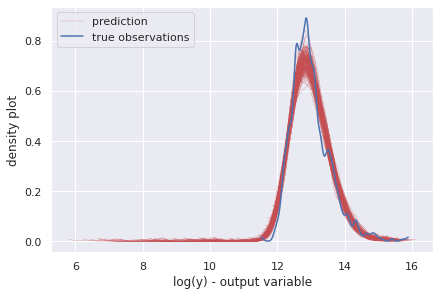

In [ ]:
## Posterior predictive checks (PPCs)

num_samples2 = 200
Ypred0 = ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xtestn0, nsamples=num_samples2)
Ypred1 = ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xtestn1, nsamples=num_samples2)
Ypred2 = ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xtestn2, nsamples=num_samples2)
Ypred3 = ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xtestn3, nsamples=num_samples2)

# Stack arrays in sequence horizontally (column wise)
Ypred = np.hstack([yscaler0.inverse_transform(Ypred0),
                 yscaler1.inverse_transform(Ypred1),
                 yscaler2.inverse_transform(Ypred2),
                 yscaler3.inverse_transform(Ypred3)])

# plot prediction shape
for i in range(Ypred.shape[0]):
    az.plot_dist( Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2})
# label
az.plot_dist(Ypred[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")

# true observations
az.plot_dist(np.log(y_test),label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

# REFERENCES

1. Analytics Vidhya. 2021. Detecting and Treating Outliers | How to Handle Outliers. [online] Available at: <https://www.analyticsvidhya.com/blog/2021/05/detecting-and-treating-outliers-treating-the-odd-one-out/> [Accessed 26 September 2021].

2. Cossairt, J., 2021. Safety for Particle Accelerators, by Thomas Otto, 2020, 148 pp. Springer Nature Switzerland AG. Gewerbestrasse 11, 6330 Cham, Switzerland; ISBN 978-3-030-57030-9 (hardcover), ISBN 978-3-030-57031-6 (pdf); https://www.springer.com/gp/book/9783030570309. Health Physics, 121(3), pp.250-250.

3. Johannemann, J., Hadad, V., Athey, S. and Wager, S., 2019. Sufficient representations for categorical variables. arXiv preprint arXiv:1908.09874.


# SUMMARY